In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import os

# 1️⃣ Vérifier et charger le dataset
file_path = "movie_data_cleaned.csv"
if not os.path.exists(file_path):
    print(f"❌ Erreur : Le fichier '{file_path}' n'existe pas !")
    exit()

df = pd.read_csv(file_path)
df.fillna("", inplace=True)


In [2]:
# 2️⃣ Vérifier les colonnes nécessaires
columns_needed = ["title", "genres", "overview", "popularity", "vote_average", "runtime", "keywords", "cast"]
missing_columns = [col for col in columns_needed if col not in df.columns]
if missing_columns:
    print(f"❌ Erreur : Colonnes manquantes dans le dataset: {missing_columns}")
    exit()

df = df[columns_needed]

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
df["genres_list"] = df["genres"].apply(lambda x: x.split(",") if isinstance(x, str) else [])
df_genres = pd.DataFrame(mlb.fit_transform(df["genres_list"]), columns=mlb.classes_)
df = pd.concat([df, df_genres], axis=1)  # Fusionner les genres binaires avec le dataset


In [4]:
 #3️⃣ Transformer les genres en variables binaires
mlb = MultiLabelBinarizer()
df["genres_list"] = df["genres"].apply(lambda x: x.split(",") if isinstance(x, str) else [])
df_genres = pd.DataFrame(mlb.fit_transform(df["genres_list"]), columns=mlb.classes_)
df = pd.concat([df, df_genres], axis=1)

In [5]:
# 4️⃣ Transformer le texte en embeddings avec gestion des erreurs
model = SentenceTransformer('all-MiniLM-L6-v2')
df["text_embedding"] = df.apply(lambda row: model.encode(row["overview"] + " " + row["keywords"] + " " + row["cast"]) if row["overview"] else np.zeros(384), axis=1)



In [6]:
# 5️⃣ Standardiser les colonnes numériques
scaler = StandardScaler()
df[["popularity", "vote_average", "runtime"]] = scaler.fit_transform(df[["popularity", "vote_average", "runtime"]])


In [7]:
print("Colonnes des genres binaires :")
print(df_genres.head())  # Vérifier les premières lignes de df_genres
print("Présence des genres dans df :")
print(df.head())  # Vérifier que les colonnes ont bien été fusionnées


Colonnes des genres binaires :
    Action   Adventure   Animation   Comedy   Crime   Documentary   Drama  \
0        0           0           0        1       0             0       0   
1        0           0           0        0       0             0       0   
2        0           0           0        1       0             0       0   
3        0           0           0        0       0             0       1   
4        0           0           0        0       0             0       0   

    Family   Fantasy   Foreign  ...  History  Horror  Music  Mystery  Romance  \
0        1         0         0  ...        0       0      0        0        0   
1        1         1         0  ...        0       0      0        0        0   
2        0         0         0  ...        0       0      0        0        1   
3        0         0         0  ...        0       0      0        0        0   
4        0         0         0  ...        0       0      0        0        0   

   Science Fiction 

In [8]:
# 6️⃣ Fusionner les embeddings, genres et données numériques
X = np.concatenate((
    np.array(df["text_embedding"].tolist()),  # Embeddings textuels
    np.array(df[["popularity", "vote_average", "runtime"]].values),  # Données numériques standardisées
    np.array(df[df_genres.columns].values)  # Genres binaires
), axis=1)


In [9]:
print(f"✅ Dimensions de X : {X.shape}")


✅ Dimensions de X : (29706, 467)


In [10]:
# 7️⃣ Appliquer K-Means Clustering (100 groupes)
num_clusters = 100
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10)
df["cluster"] = kmeans.fit_predict(X)

In [11]:
print(df["cluster"].value_counts())  # Nombre de films par groupe


cluster
79    1790
59    1528
2     1476
3     1332
37    1223
      ... 
38      15
43      12
11      11
14       3
6        1
Name: count, Length: 100, dtype: int64


In [11]:
cluster_num = 5
movies_in_cluster = df[df["cluster"] == cluster_num]["title"].tolist()
print(f"🎬 Films du cluster {cluster_num}: {movies_in_cluster[:10]}")  # Affiche les 10 premiers


🎬 Films du cluster 5: ['Dream Man', 'The Old Lady Who Walked in the Sea', 'After Image', 'Sweepers', 'Come On, Rangers', 'Live Music', 'Nazty Nuisance', 'My Avatar and Me', 'Find Love', 'Bells of Capistrano']


In [12]:
sample_movie = df[df["title"] == "Inception"]
predicted_cluster = sample_movie["cluster"].values[0]
movies_recommended = df[df["cluster"] == predicted_cluster]["title"].tolist()
print(f"🎬 Films similaires à 'Inception': {movies_recommended[:10]}")


🎬 Films similaires à 'Inception': ['Star Wars', 'Forrest Gump', "Schindler's List", 'DragonHeart', 'The Godfather', '2001: A Space Odyssey', "One Flew Over the Cuckoo's Nest", 'Psycho', 'The Godfather: Part II', 'Once Upon a Time in America']


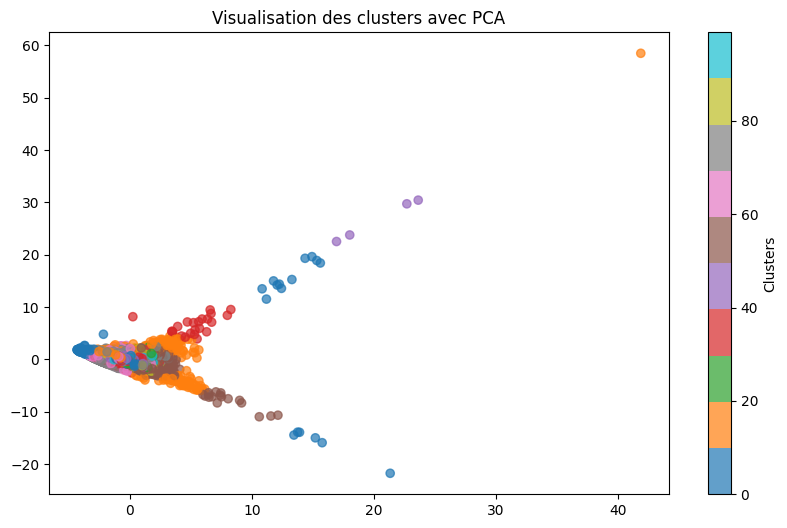

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["cluster"], cmap="tab10", alpha=0.7)
plt.colorbar(label="Clusters")
plt.title("Visualisation des clusters avec PCA")
plt.show()


In [16]:
def get_movie_recommendations(df):
    user_movie = input("🎬 Entrez le titre du film que vous aimez : ")
    
    if user_movie not in df["title"].values:
        print("❌ Désolé, ce film n'est pas dans la base de données.")
        return
    
    user_cluster = df[df["title"] == user_movie]["cluster"].values[0]
    cluster_df = df[df["cluster"] == user_cluster].copy()

    user_embedding = df[df["title"] == user_movie]["text_embedding"].values[0]
    
    if isinstance(user_embedding, float):  
        print(f"❌ Pas d'embedding disponible pour '{user_movie}'.")
        return
    
    similarities = cosine_similarity([user_embedding], np.array(cluster_df["text_embedding"].tolist()))[0]
    
    cluster_df["similarity_score"] = similarities
    cluster_df["popularity_norm"] = cluster_df["popularity"] / cluster_df["popularity"].max()
    cluster_df["vote_norm"] = cluster_df["vote_average"] / cluster_df["vote_average"].max()
    cluster_df["runtime_norm"] = cluster_df["runtime"] / cluster_df["runtime"].max()

    cluster_df["score"] = (
        0.50 * cluster_df["similarity_score"] +
        0.20 * cluster_df["popularity_norm"] +
        0.20 * cluster_df["vote_norm"] +
        0.10 * cluster_df["runtime_norm"]
    )

    sorted_movies = cluster_df.sort_values("score", ascending=False)[["title", "score"]]
    top_movies = sorted_movies[sorted_movies["title"] != user_movie].head(5)

    print(f"\n🎬 Films recommandés pour '{user_movie}':")
    for _, row in top_movies.iterrows():
        print(f"👉 {row['title']} (Score: {row['score']:.2f})")

# Exécuter la fonction
get_movie_recommendations(df)




🎬 Films recommandés pour 'Toy Story':
👉 Toy Story 3 (Score: 0.64)
👉 Toy Story 2 (Score: 0.62)
👉 Monsters, Inc. (Score: 0.47)
👉 Zootopia (Score: 0.44)
👉 E.T. the Extra-Terrestrial (Score: 0.44)


In [17]:
import joblib

# 📂 Sauvegarde du modèle K-Means
joblib.dump(kmeans, "kmeans_model.pkl")
print("✅ Modèle K-Means sauvegardé avec succès ! 📂")


✅ Modèle K-Means sauvegardé avec succès ! 📂


In [18]:
df.to_csv("movie_data.csv", index=False)
print("✅ Fichier 'movie_data.csv' sauvegardé avec succès !")


✅ Fichier 'movie_data.csv' sauvegardé avec succès !


In [19]:
print(df[df["title"] == "Heat"][["title", "text_embedding"]])




      title                                     text_embedding
5      Heat  [0.003090151, -0.11548835, -0.079643115, -0.06...
12194  Heat  [-0.07012973, -0.06617549, 0.004856588, 0.0129...


In [ ]:
import streamlit as st
import joblib

@st.cache_resource
def load_model():
    return joblib.load("kmeans_model.pkl")

kmeans_model = load_model()

st.title("🎬 Recommandation de Films")
user_movie = st.text_input("🔍 Entrez un film :")

if st.button("Recommander"):
    if user_movie:
        cluster = kmeans_model.predict(df[["popularity", "vote_average"]])
        st.success(f"✅ Ce film appartient au cluster {cluster[0]}")
    else:
        st.warning("⚠️ Veuillez entrer un film valide.")


In [9]:
# 9️⃣ Fonction de recommandation avec gestion des erreurs
def recommend_movies_weighted(user_movie, df):
    if user_movie not in df["title"].values:
        print("❌ Désolé, ce film n'est pas dans la base de données.")
        return
    
    user_cluster = df[df["title"] == user_movie]["cluster"].values[0]
    cluster_df = df[df["cluster"] == user_cluster].copy()

    user_embedding = df[df["title"] == user_movie]["text_embedding"].values[0]
    
    # Vérifier que les embeddings ne sont pas vides
    if isinstance(user_embedding, float):  
        print(f"❌ Pas d'embedding disponible pour '{user_movie}'.")
        return
    
    similarities = cosine_similarity([user_embedding], np.array(cluster_df["text_embedding"].tolist()))[0]

    cluster_df["popularity_norm"] = cluster_df["popularity"] / cluster_df["popularity"].max()
    cluster_df["vote_norm"] = cluster_df["vote_average"] / cluster_df["vote_average"].max()
    cluster_df["runtime_norm"] = cluster_df["runtime"] / cluster_df["runtime"].max()

    cluster_df["score"] = (
        0.50 * similarities +
        0.20 * cluster_df["popularity_norm"] +
        0.20 * cluster_df["vote_norm"] +
        0.10 * cluster_df["runtime_norm"]
    )

    sorted_movies = cluster_df.sort_values("score", ascending=False)[["title", "score"]]
    top_movies = sorted_movies[sorted_movies["title"] != user_movie].head(5)

    print(f"\n🎬 Films recommandés pour '{user_movie}':")
    for _, row in top_movies.iterrows():
        print(f"👉 {row['title']} (Score: {row['score']:.2f})")

In [34]:
print(df["text_embedding"].head())  # Vérifier la structure des embeddings


0    [-0.028885882, -0.040720213, 0.08457188, -0.08...
1    [0.012158036, -0.01563346, -0.020215897, -0.01...
2    [-0.11555737, 0.010200933, -0.023194058, -0.07...
3    [-0.07016937, -0.09782038, -0.021666659, 0.043...
4    [-0.033900864, -0.06971271, 0.046093374, 0.025...
Name: text_embedding, dtype: object


# hahowa fach kanbkhi nexcute bmodéle sauvegardé makibkhich

In [ ]:
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import ast  # Importer AST pour une conversion sécurisée

# 🔹 Charger le modèle et les données
def load_model_and_data():
    print("📂 Chargement du modèle et des données...")
    kmeans_loaded = joblib.load("kmeans_model.pkl")
    df = pd.read_csv("movie_data.csv")

    # 🔍 Vérifier la structure des embeddings
    print("✅ Vérification des données...")
    print(df["text_embedding"].head(10))  # Vérifie les premières valeurs

    # 🔹 Nettoyer les données avant la conversion
    df = df[df["text_embedding"].notna()]  # Supprimer les NaN
    df["text_embedding"] = df["text_embedding"].astype(str)  # Convertir en chaîne
    df = df[df["text_embedding"] != "None"]
    df = df[df["text_embedding"] != "NULL"]

    # 🔹 Convertir les embeddings en tableaux NumPy (corrigé avec `ast.literal_eval`)
    def clean_embedding(x):
        try:
            return np.array(ast.literal_eval(x)) if isinstance(x, str) else x
        except:
            print(f"❌ Erreur de conversion pour : {x}")
            return None  # Garde uniquement les valeurs valides
    
    df["text_embedding"] = df["text_embedding"].apply(clean_embedding)
    df = df[df["text_embedding"].notna()]  # Supprimer les erreurs

    print("✅ Modèle et données chargés avec succès !")
    return kmeans_loaded, df

# 🔹 Fonction de recommandation avec test utilisateur
def get_movie_recommendations(df):
    user_movie = input("🎬 Entrez le titre du film que vous aimez : ")
    
    if user_movie not in df["title"].values:
        print(f"❌ Désolé, '{user_movie}' n'est pas dans la base de données.")
        return
    
    user_cluster = df[df["title"] == user_movie]["cluster"].values[0]
    cluster_df = df[df["cluster"] == user_cluster].copy()

    user_embedding = df[df["title"] == user_movie]["text_embedding"].values[0]
    
    if isinstance(user_embedding, float):  
        print(f"❌ Pas d'embedding disponible pour '{user_movie}'.")
        return
    
    similarities = cosine_similarity([user_embedding], np.array(cluster_df["text_embedding"].tolist()))[0]
    
    cluster_df["similarity_score"] = similarities
    cluster_df["popularity_norm"] = cluster_df["popularity"] / cluster_df["popularity"].max()
    cluster_df["vote_norm"] = cluster_df["vote_average"] / cluster_df["vote_average"].max()
    cluster_df["runtime_norm"] = cluster_df["runtime"] / cluster_df["runtime"].max()

    cluster_df["score"] = (
        0.50 * cluster_df["similarity_score"] +
        0.20 * cluster_df["popularity_norm"] +
        0.20 * cluster_df["vote_norm"] +
        0.10 * cluster_df["runtime_norm"]
    )

    sorted_movies = cluster_df.sort_values("score", ascending=False)[["title", "score"]]
    top_movies = sorted_movies[sorted_movies["title"] != user_movie].head(5)

    print(f"\n🎬 Films recommandés pour '{user_movie}':")
    for _, row in top_movies.iterrows():
        print(f"👉 {row['title']} (Score: {row['score']:.2f})")

# 🔹 Charger le modèle et les données avant exécution
kmeans_loaded, df = load_model_and_data()

# 🔹 Exécuter la fonction de test
get_movie_recommendations(df)


📂 Chargement du modèle et des données...
